In [49]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np


In [50]:
## settings (move to yaml file for routines)

server_url = 'http://akutan.pmel.noaa.gov:8080/erddap'
maxdepth = 0 #keep all data above this depth
site_str = 'M8'
region = 'bs'
substring = ['bs8','bs8'] #search substring useful for M2
prelim=[]

#this elimnates bad salinity but 
data_QC = True


In [51]:
e = ERDDAP(server=server_url)
df = pd.read_csv(e.get_search_url(response='csv', search_for=f'datasets_Mooring AND {region}'))
#print(df['Dataset ID'].values)

In [52]:
from requests.exceptions import HTTPError

dfs = {}

for dataset_id in sorted(df['Dataset ID'].values):
    if ('1hr' in dataset_id):
        continue
    if any(x in dataset_id for x in substring) and not any(x in dataset_id for x in prelim) and ('final' in dataset_id):

        print(dataset_id)
        try:
            d = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv'
            )
            d.dataset_id=dataset_id
            d.variables = ['latitude',
                           'longitude',
                           'depth',
                           'Chlorophyll_Fluorescence',
                           'time',
                           'timeseries_id']
            d.constraints = {'depth>=':maxdepth}
        except HTTPError:
            print('Failed to generate url {}'.format(dataset_id))

        try:
            df_m = d.to_pandas(
                        index_col='time (UTC)',
                        parse_dates=True,
                        skiprows=(1,)  # units information can be dropped.
                        )
            df_m.sort_index(inplace=True)
            df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]

            dfs.update({dataset_id:df_m})
        except:
            pass
    if any(x in dataset_id for x in prelim) and ('preliminary' in dataset_id):
        print(dataset_id)
        try:
            d = ERDDAP(server=server_url,
                protocol='tabledap',
                response='csv'
            )
            d.dataset_id=dataset_id
            d.variables = ['latitude',
                           'longitude',
                           'depth',
                           'Chlorophyll_Fluorescence',
                           'time',
                           'timeseries_id']
            d.constraints = {'depth>=':maxdepth}
        except HTTPError:
            print('Failed to generate url {}'.format(dataset_id))

        try:
            df_m = d.to_pandas(
                        index_col='time (UTC)',
                        parse_dates=True,
                        skiprows=(1,)  # units information can be dropped.
                        )
            df_m.sort_index(inplace=True)
            df_m.columns = [x[1].split()[0] for x in enumerate(df_m.columns)]

            #using preliminary for unfinished datasets - very simple qc
            if data_QC:

                #overwinter moorings
                if '17bs2c' in dataset_id:
                    df_m=df_m['2017-10-3':'2018-5-1']
                if '16bs2c' in dataset_id:
                    df_m=df_m['2016-10-6':'2017-4-26']
                if '17bsm2a' in dataset_id:
                    df_m=df_m['2017-4-28':'2017-9-22']
                if '18bsm2a' in dataset_id:
                    df_m=df_m['2018-4-30':'2018-10-01']
                
                if '17bs8a' in dataset_id:
                    df_m=df_m['2017-9-30':'2018-10-1']
                if '18bs8a' in dataset_id:
                    df_m=df_m['2018-10-12':'2019-9-23']   

                if '16bs4b' in dataset_id:
                    df_m=df_m['2016-9-26':'2017-9-24']
                if '17bs4b' in dataset_id:
                    df_m=df_m['2017-9-30':'2018-10-1']
                if '18bs4b' in dataset_id:
                    df_m=df_m['2018-10-12':'2018-9-23']   
                    
                if '13bs5a' in dataset_id:
                    df_m=df_m['2013-8-18':'2014-10-16']
                if '14bs5a' in dataset_id:
                    df_m=df_m['2014-10-16':'2015-9-24']
                if '16bs5a' in dataset_id:
                    df_m=df_m['2016-9-26':'2017-9-24']
                if '17bs5a' in dataset_id:
                    df_m=df_m['2017-9-30':'2018-10-1']
                if '18bs5a' in dataset_id:
                    df_m=df_m['2018-10-12':'2018-9-23']   
            dfs.update({dataset_id:df_m})
        except:
            pass

datasets_Mooring_05bs8a_final
datasets_Mooring_05bs8b_final
datasets_Mooring_06bs8a_final
datasets_Mooring_07bs8a_final
datasets_Mooring_08bs8a_final
datasets_Mooring_09bs8a_final
datasets_Mooring_10bs8a_final
datasets_Mooring_11bs8a_final
datasets_Mooring_12bs8a_final
datasets_Mooring_13bs8a_final
datasets_Mooring_14bs8a_final
datasets_Mooring_15bs8a_final
datasets_Mooring_16bs8a_final
datasets_Mooring_17bs8a_final
datasets_Mooring_18bs8a_final


In [53]:
df_merged=pd.DataFrame()
for dataset_id in dfs.keys():
    df_merged = df_merged.append(dfs[dataset_id])

In [54]:
df_merged.describe()

,latitude,longitude,depth,Chlorophyll_Fluorescence
count,6.451837e+06,6.451837e+06,6.460069e+06,73176.000000
mean,6.219432e+01,1.853268e+02,4.217627e+01,3.409844
std,1.562018e-03,8.347783e-03,1.496241e+01,7.406204
min,6.219268e+01,1.853116e+02,1.400000e+01,-0.357500
25%,6.219370e+01,1.853165e+02,2.700000e+01,0.445325
50%,6.219390e+01,1.853322e+02,4.000000e+01,1.522679
75%,6.219430e+01,1.853325e+02,5.100000e+01,3.322872
max,6.219930e+01,1.853339e+02,7.100000e+01,124.108000


In [55]:
df_merged = df_merged.dropna()

In [56]:
import matplotlib as mpl
import matplotlib.pyplot as plt

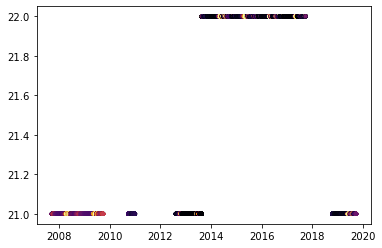

In [57]:
plt.scatter(df_merged.index, y=df_merged['depth'], s=10, c=df_merged['Chlorophyll_Fluorescence'], vmin=0, vmax=10, cmap='inferno')

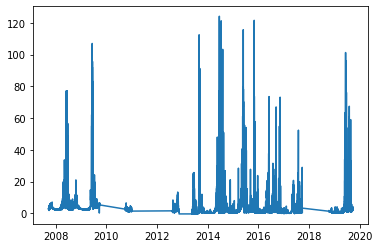

In [58]:
plt.plot(df_merged.index, df_merged['Chlorophyll_Fluorescence'])

In [59]:
df_merged.to_csv(f'{site_str}_nearsfc_chlor.csv')